# Classifying the $logS$ values of a molecule using its MACCS fingerprints

## Setting up the notebook and importing necessary libraries

In [ ]:
!pip install rdkit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Chemistry
from rdkit import Chem
from rdkit.Chem import MACCSkeys

## Loading and Analyzing the ESol dataset

In [42]:
def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    df = df[['smiles', 'measured log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()


CUTOFF = -2.0  # Example cutoff for solubility classification
df['SolubilityClass'] = np.where(df['LogS'] < CUTOFF, 0, 1)

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


Plotting the distribution of $logS$ values

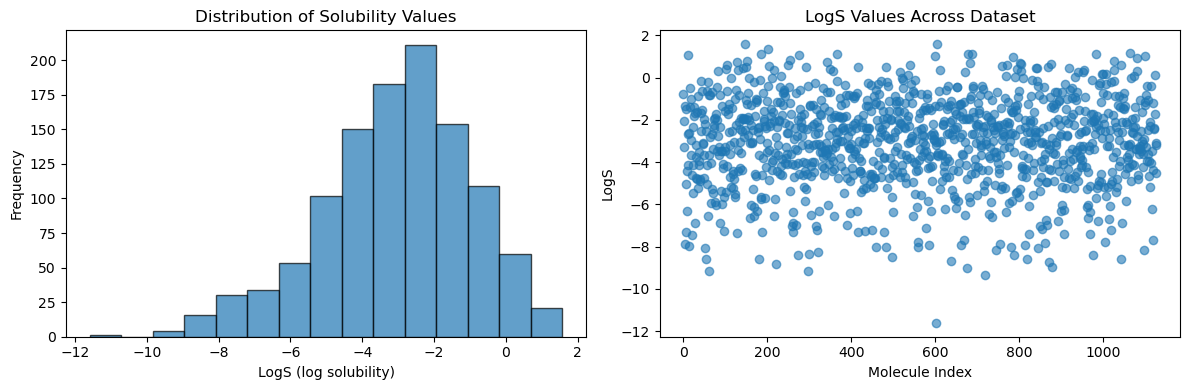

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

## Setting Hyperparameters and Generating Fingerprints

In [44]:
BATCH_SIZE = 1 #batch size for training (can try : 16,32,64)
NUM_EPOCHS = 100 #number of epochs
WEIGHT_DECAY = 1e-3 #coefficient to be used in regularisation
LEARNING_RATE = 1e-3 #learning rate
PATIENCE = 3 #number of epochs to wait before reducing learning rate
FACTOR = 0.5 #factor by which to reduce learning rate
EARLY_STOPPING = 10 #number of epochs to wait before stopping training if validation loss does not improve
DROPOUT = 0.2 #dropout rate for regularisation

Generating MACCS fingerprints with the help of RDkit. MACCS (Molecular ACCess System) fingerprints are a set of 166 predefined structural keys used in cheminformatics to digitally represent molecules as binary strings (0s and 1s), indicating the presence or absence of specific chemical fragments, making them excellent for comparing molecules and searching chemical databases

In [45]:
maccs = []

for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    maccs_fp = np.array(MACCSkeys.GenMACCSKeys(mol))
    maccs.append(maccs_fp)

df["maccs"] = maccs

### Visualizing frequency of number of bits turned on in MACCS fingerprints. This plot will give us some insight into the dataset

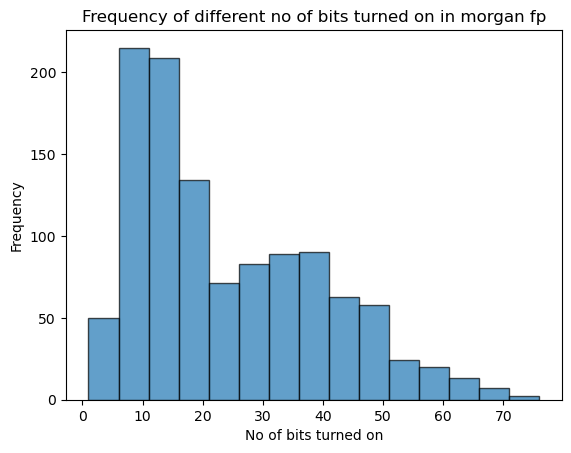

In [46]:
num_ones = [] #list containing no of ones in morgan fp of molecules
for _,row in df.iterrows():
    num_ones.append(np.sum(row['maccs']))
plt.title("Frequency of different no of bits turned on in morgan fp")
plt.hist(num_ones,bins=15,alpha=0.7,edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel("No of bits turned on")
plt.show()

### Defining a PyTorch `Dataset` class and instantiating the `Dataloaders`

In [47]:
class FPDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
X_train, X_test, y_train, y_test = train_test_split(
    df['maccs'].values, df['SolubilityClass'].values, #as we are predicting both LogS and LogP
    test_size=0.2, random_state=42
)

train_dataset = FPDataset(X_train,y_train)
test_dataset = FPDataset(X_test,y_test)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle = False)

# Defining a 2-layer MLP model, setting the loss criterion, optimizer and instantiating the model

In [48]:
class MLP(nn.Module):
    def __init__(self,input_channels=167,num_classes=2):
        super(MLP, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,100), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(DROPOUT), #dropout for regularisation
            nn.Linear(100,50), #hidden layer 2
            nn.ReLU(),
            nn.Dropout(DROPOUT), #dropout for regularisation
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY) #weight decay for regularisation
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=PATIENCE, factor=FACTOR) #reduce learning rate by 0.5 if validation loss does not improve for 3 epochs


## Training the classification model

In [50]:
def train_model(model,train_loader,test_loader,num_epochs=NUM_EPOCHS):
    train_losses = [] #list to store training losses

    all_predictions = [] #list to store predictions
    all_logs = [] #list to store true values

    test_losses = [] #list to store test losses

    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for fp, logs in tqdm(train_loader,desc="training"):
            logs = logs.float().to(device)
            fp = fp.float().to(device)

            optimizer.zero_grad() # Zero the gradients,or else they will keep accumulating
            outputs = model(fp)

            loss = criterion(outputs, logs.unsqueeze(1))
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        model.eval() #disables dropout and other regularization

        test_loss = 0.0

        all_predictions = []
        all_logs = []

        with torch.no_grad():
            for fp,logs in tqdm(test_loader,desc="testing"):
                logs = logs.float().to(device)
                fp = fp.float().to(device)
                outputs = model(fp)

                loss = criterion(outputs, logs.unsqueeze(1))  # LogS loss
                test_loss += loss.item()

            test_loss = test_loss / len(test_loader)

            scheduler.step(test_loss)

            if(epoch>0):
                if test_loss > test_losses[-1]:  # Check if the test loss has increased
                    early_stopping_counter += 1
                elif abs(test_loss - test_losses[-1]) < 1e-4:  # Check if the test loss has not changed significantly
                    early_stopping_counter += 1
                else:
                    early_stopping_counter = 0
                
            if early_stopping_counter >= EARLY_STOPPING:
                break
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f},')
    return train_losses, test_losses


In [51]:
train_losses, test_losses = train_model(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 1984.02it/s]


Epoch [1/100], Train Loss: 0.6829, Test Loss: 0.6509,


testing: 100%|██████████| 226/226 [00:00<00:00, 2023.82it/s]


Epoch [2/100], Train Loss: 0.6532, Test Loss: 0.6440,


testing: 100%|██████████| 226/226 [00:00<00:00, 2636.18it/s]


Epoch [3/100], Train Loss: 0.6402, Test Loss: 0.6430,


testing: 100%|██████████| 226/226 [00:00<00:00, 2836.24it/s]


Epoch [4/100], Train Loss: 0.6381, Test Loss: 0.6352,


testing: 100%|██████████| 226/226 [00:00<00:00, 2752.26it/s]


Epoch [5/100], Train Loss: 0.6381, Test Loss: 0.6352,


testing: 100%|██████████| 226/226 [00:00<00:00, 2722.43it/s]


Epoch [6/100], Train Loss: 0.6349, Test Loss: 0.6473,


testing: 100%|██████████| 226/226 [00:00<00:00, 2844.10it/s]


Epoch [7/100], Train Loss: 0.6412, Test Loss: 0.6388,


testing: 100%|██████████| 226/226 [00:00<00:00, 2634.91it/s]


Epoch [8/100], Train Loss: 0.6356, Test Loss: 0.6386,


testing: 100%|██████████| 226/226 [00:00<00:00, 2275.85it/s]


Epoch [9/100], Train Loss: 0.6259, Test Loss: 0.6261,


testing: 100%|██████████| 226/226 [00:00<00:00, 2527.65it/s]


Epoch [10/100], Train Loss: 0.6279, Test Loss: 0.6270,


testing: 100%|██████████| 226/226 [00:00<00:00, 2850.17it/s]


Epoch [11/100], Train Loss: 0.6247, Test Loss: 0.6288,


testing: 100%|██████████| 226/226 [00:00<00:00, 2300.70it/s]


Epoch [12/100], Train Loss: 0.6237, Test Loss: 0.6248,


testing: 100%|██████████| 226/226 [00:00<00:00, 2788.66it/s]


Epoch [13/100], Train Loss: 0.6218, Test Loss: 0.6279,


testing: 100%|██████████| 226/226 [00:00<00:00, 2417.61it/s]


Epoch [14/100], Train Loss: 0.6217, Test Loss: 0.6280,


testing: 100%|██████████| 226/226 [00:00<00:00, 2330.63it/s]


Epoch [15/100], Train Loss: 0.6203, Test Loss: 0.6263,


testing: 100%|██████████| 226/226 [00:00<00:00, 2719.04it/s]


Epoch [16/100], Train Loss: 0.6180, Test Loss: 0.6289,


testing: 100%|██████████| 226/226 [00:00<00:00, 2821.46it/s]


Epoch [17/100], Train Loss: 0.6173, Test Loss: 0.6248,


testing: 100%|██████████| 226/226 [00:00<00:00, 2812.42it/s]


Epoch [18/100], Train Loss: 0.6154, Test Loss: 0.6241,


testing: 100%|██████████| 226/226 [00:00<00:00, 2556.70it/s]


Epoch [19/100], Train Loss: 0.6139, Test Loss: 0.6221,


testing: 100%|██████████| 226/226 [00:00<00:00, 2279.28it/s]


Epoch [20/100], Train Loss: 0.6134, Test Loss: 0.6215,


testing: 100%|██████████| 226/226 [00:00<00:00, 2290.34it/s]


Epoch [21/100], Train Loss: 0.6148, Test Loss: 0.6227,


testing: 100%|██████████| 226/226 [00:00<00:00, 2366.05it/s]


Epoch [22/100], Train Loss: 0.6123, Test Loss: 0.6228,


testing: 100%|██████████| 226/226 [00:00<00:00, 2177.19it/s]


Epoch [23/100], Train Loss: 0.6127, Test Loss: 0.6214,


testing: 100%|██████████| 226/226 [00:00<00:00, 2845.67it/s]


Epoch [24/100], Train Loss: 0.6092, Test Loss: 0.6241,


testing: 100%|██████████| 226/226 [00:00<00:00, 2854.19it/s]


Epoch [25/100], Train Loss: 0.6118, Test Loss: 0.6210,


testing: 100%|██████████| 226/226 [00:00<00:00, 2830.30it/s]


Epoch [26/100], Train Loss: 0.6102, Test Loss: 0.6201,


testing: 100%|██████████| 226/226 [00:00<00:00, 2852.43it/s]


Epoch [27/100], Train Loss: 0.6107, Test Loss: 0.6225,


testing: 100%|██████████| 226/226 [00:00<00:00, 2855.28it/s]


Epoch [28/100], Train Loss: 0.6086, Test Loss: 0.6223,


testing: 100%|██████████| 226/226 [00:00<00:00, 2812.02it/s]


Epoch [29/100], Train Loss: 0.6088, Test Loss: 0.6211,


testing: 100%|██████████| 226/226 [00:00<00:00, 2097.44it/s]


Epoch [30/100], Train Loss: 0.6095, Test Loss: 0.6196,


testing: 100%|██████████| 226/226 [00:00<00:00, 2865.36it/s]


Epoch [31/100], Train Loss: 0.6078, Test Loss: 0.6209,


testing: 100%|██████████| 226/226 [00:00<00:00, 2841.72it/s]


Epoch [32/100], Train Loss: 0.6075, Test Loss: 0.6211,


testing: 100%|██████████| 226/226 [00:00<00:00, 2269.49it/s]


Epoch [33/100], Train Loss: 0.6085, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2089.17it/s]


Epoch [34/100], Train Loss: 0.6068, Test Loss: 0.6210,


testing: 100%|██████████| 226/226 [00:00<00:00, 2259.08it/s]


Epoch [35/100], Train Loss: 0.6071, Test Loss: 0.6232,


testing: 100%|██████████| 226/226 [00:00<00:00, 2230.79it/s]


Epoch [36/100], Train Loss: 0.6065, Test Loss: 0.6239,


testing: 100%|██████████| 226/226 [00:00<00:00, 2785.28it/s]


Epoch [37/100], Train Loss: 0.6072, Test Loss: 0.6218,


testing: 100%|██████████| 226/226 [00:00<00:00, 2799.05it/s]


Epoch [38/100], Train Loss: 0.6042, Test Loss: 0.6195,


testing: 100%|██████████| 226/226 [00:00<00:00, 2847.95it/s]


Epoch [39/100], Train Loss: 0.6040, Test Loss: 0.6204,


testing: 100%|██████████| 226/226 [00:00<00:00, 2825.36it/s]


Epoch [40/100], Train Loss: 0.6047, Test Loss: 0.6199,


testing: 100%|██████████| 226/226 [00:00<00:00, 2390.75it/s]


Epoch [41/100], Train Loss: 0.6038, Test Loss: 0.6203,


testing: 100%|██████████| 226/226 [00:00<00:00, 2260.23it/s]


Epoch [42/100], Train Loss: 0.6042, Test Loss: 0.6199,


testing: 100%|██████████| 226/226 [00:00<00:00, 2842.67it/s]


Epoch [43/100], Train Loss: 0.6038, Test Loss: 0.6197,


testing: 100%|██████████| 226/226 [00:00<00:00, 2720.17it/s]


Epoch [44/100], Train Loss: 0.6036, Test Loss: 0.6189,


testing: 100%|██████████| 226/226 [00:00<00:00, 2670.19it/s]


Epoch [45/100], Train Loss: 0.6027, Test Loss: 0.6184,


testing: 100%|██████████| 226/226 [00:00<00:00, 2870.53it/s]


Epoch [46/100], Train Loss: 0.6028, Test Loss: 0.6190,


testing: 100%|██████████| 226/226 [00:00<00:00, 2876.81it/s]


Epoch [47/100], Train Loss: 0.6032, Test Loss: 0.6189,


testing: 100%|██████████| 226/226 [00:00<00:00, 2875.35it/s]


Epoch [48/100], Train Loss: 0.6030, Test Loss: 0.6191,


testing: 100%|██████████| 226/226 [00:00<00:00, 2852.34it/s]


Epoch [49/100], Train Loss: 0.6026, Test Loss: 0.6194,


testing: 100%|██████████| 226/226 [00:00<00:00, 2612.38it/s]


Epoch [50/100], Train Loss: 0.6013, Test Loss: 0.6190,


testing: 100%|██████████| 226/226 [00:00<00:00, 2631.57it/s]


Epoch [51/100], Train Loss: 0.6018, Test Loss: 0.6191,


testing: 100%|██████████| 226/226 [00:00<00:00, 2873.72it/s]


Epoch [52/100], Train Loss: 0.6011, Test Loss: 0.6189,


testing: 100%|██████████| 226/226 [00:00<00:00, 2595.98it/s]


Epoch [53/100], Train Loss: 0.6019, Test Loss: 0.6189,


testing: 100%|██████████| 226/226 [00:00<00:00, 2859.98it/s]


Epoch [54/100], Train Loss: 0.6012, Test Loss: 0.6191,


testing: 100%|██████████| 226/226 [00:00<00:00, 2353.53it/s]


Epoch [55/100], Train Loss: 0.6010, Test Loss: 0.6187,


testing: 100%|██████████| 226/226 [00:00<00:00, 2843.26it/s]


Epoch [56/100], Train Loss: 0.6014, Test Loss: 0.6188,


testing: 100%|██████████| 226/226 [00:00<00:00, 2724.82it/s]


Epoch [57/100], Train Loss: 0.6018, Test Loss: 0.6187,


testing: 100%|██████████| 226/226 [00:00<00:00, 2389.60it/s]


Epoch [58/100], Train Loss: 0.6014, Test Loss: 0.6188,


testing: 100%|██████████| 226/226 [00:00<00:00, 2568.97it/s]


Epoch [59/100], Train Loss: 0.6015, Test Loss: 0.6188,


testing: 100%|██████████| 226/226 [00:00<00:00, 2873.05it/s]


Epoch [60/100], Train Loss: 0.6017, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2416.17it/s]


Epoch [61/100], Train Loss: 0.6017, Test Loss: 0.6187,


testing: 100%|██████████| 226/226 [00:00<00:00, 2107.20it/s]


Epoch [62/100], Train Loss: 0.6023, Test Loss: 0.6187,


testing: 100%|██████████| 226/226 [00:00<00:00, 2848.05it/s]


Epoch [63/100], Train Loss: 0.6008, Test Loss: 0.6187,


testing: 100%|██████████| 226/226 [00:00<00:00, 2830.74it/s]


Epoch [64/100], Train Loss: 0.6012, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2849.47it/s]


Epoch [65/100], Train Loss: 0.6016, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2858.63it/s]


Epoch [66/100], Train Loss: 0.6003, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2849.94it/s]


Epoch [67/100], Train Loss: 0.6011, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2150.66it/s]


Epoch [68/100], Train Loss: 0.6008, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2865.23it/s]


Epoch [69/100], Train Loss: 0.6002, Test Loss: 0.6186,


testing: 100%|██████████| 226/226 [00:00<00:00, 2868.74it/s]


## Evaluating model performance with Visualizations

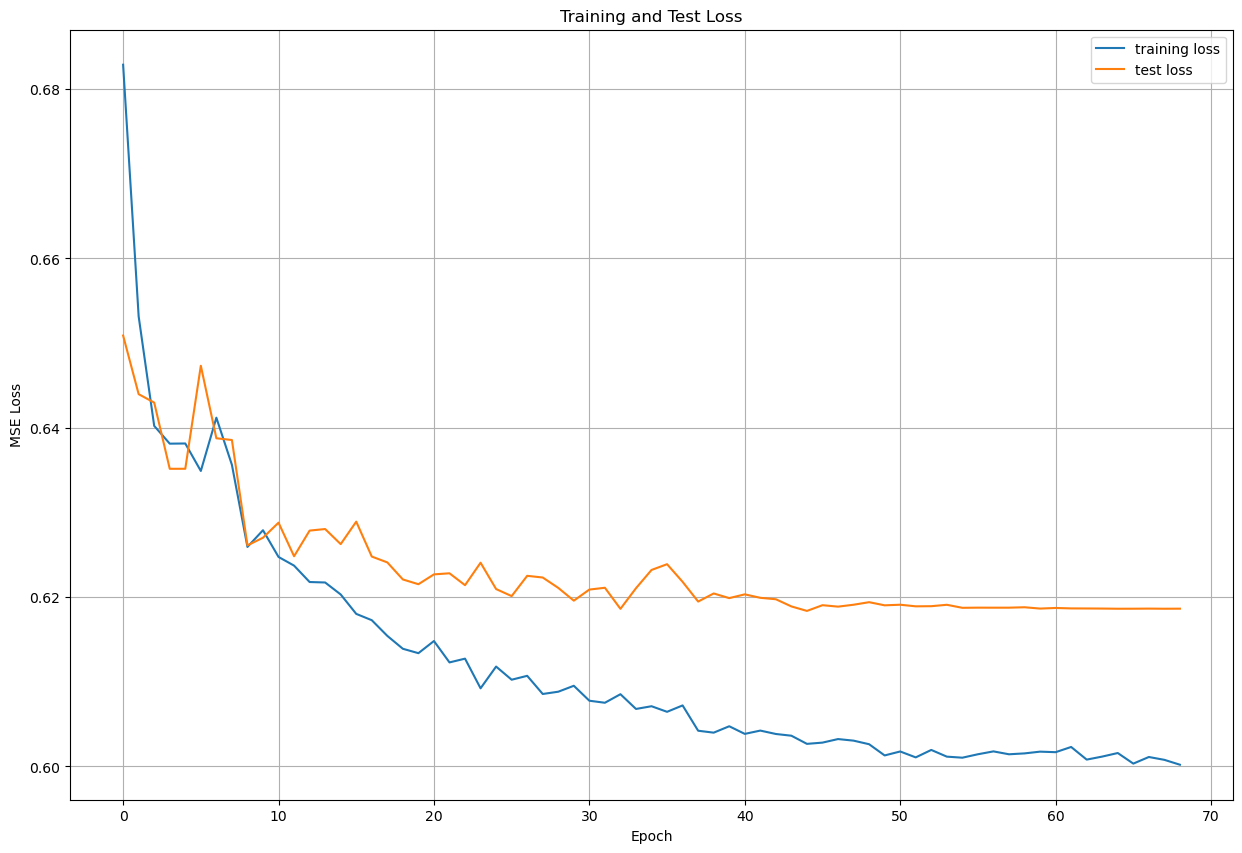

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

### Comparing Test Set predictions with Actual Values

evaluating: 100%|██████████| 226/226 [00:00<00:00, 3128.02it/s]


Accuracy on test set: 0.8805


AttributeError: Line2D.set() got an unexpected keyword argument 'annot'

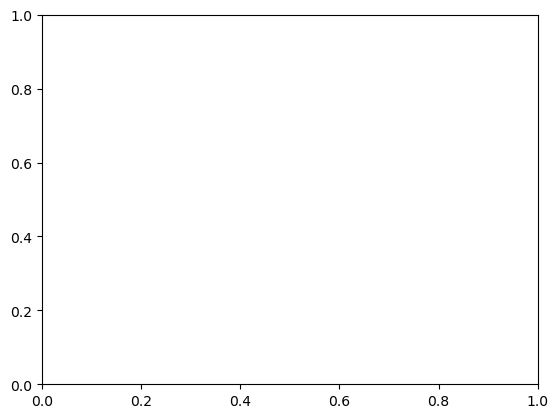

In [53]:
preds = []
targets = []

model.eval()
with torch.no_grad():
    for fp, logs in tqdm(test_loader, desc="evaluating"):
        logs = logs.float().to(device)
        fp = fp.float().to(device)
        outputs = model(fp)

        preds.extend(outputs.cpu().numpy())
        targets.extend(logs.cpu().numpy())
preds = np.array(preds).flatten()
targets = np.array(targets).flatten()

predicted_classes = (preds >= 0.5).astype(int)
accuracy = np.mean(predicted_classes == targets)
print(f'Accuracy on test set: {accuracy:.4f}')

cm = confusion_matrix(targets, predicted_classes)
plt.plot(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()